* Name: Gustavo Alejandro Chavez
* Capstone Project: Architectural Style Periods Detector
* Cohort Lead: Abhineet Kulkarni

# Introduction
This is my capstone project for Flatiron School. I have always had an interest in architecture and used this project as an opportunity to explore that. I have organized a variety or architectural styles into one of 9 different broader categories. The data for this notebook is a combination of data gathered from Google Images and a dataset found here on Kaggle. This notebook was executed on kaggle and is thus written to be executed on kaggle with the corresponding dataset.

Link to my dataset can be found in my readme and also here [Kaggle link to data](https://www.kaggle.com/gustavoachavez/architectural-styles-periods-dataset)

## Imports

In [1]:
import os, shutil
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
import datetime
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Importing Data and separating into train/val/test sets

In [2]:
os.listdir('../')

['lib', 'input', 'working']

In [3]:
root_dir = '../input/architectural-styles-periods-dataset/Capstone_Architectural_Styles_dataset/'
periods= os.listdir(root_dir)
rootdir = '/kaggle/'

#will use styles as our classes dir

val_ratio =0.10
test_ratio = 0.10
#run only once
for period in periods:
    os.makedirs(rootdir +'train/'+ period)
    os.makedirs(rootdir +'val/'+ period)
    os.makedirs(rootdir +'test/'+ period)

A few images within the dataset are unusable in processing. Here I create a copy of all images to root them out.

In [4]:
#Creates a new directory containing all images
os.makedirs(rootdir+'allimages/')
for period in periods:
    styles_in_period = os.listdir(root_dir+period)
    for style in styles_in_period:
        src = root_dir + period + '/' + style
        allFileNames = os.listdir(src)
        allImgNames = [src+'/'+ name for name in allFileNames]
        for name in allImgNames:
            shutil.copy(name, rootdir +'allimages/')

In [5]:
imageFolder = '/kaggle/allimages/'
listImages = os.listdir('/kaggle/allimages/')

#Checks if the image has exif data. If it does not, image is added into an errored images list
errored_images = []
for img in listImages:
    imgPath = os.path.join(imageFolder,img)
            
    try:
        imag = Image.open(imgPath)
        exif_data = imag._getexif()
        
    except:
        print("Error on image: ", img)
        errored_images.append(img)
    

Error on image:  3288.jpg
Error on image:  129.jpg
Error on image:  2233.jpg
Error on image:  5293.jpg
Error on image:  7624.jpg
Error on image:  3333.jpg


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Error on image:  7127.jpg
Error on image:  1529.jpg


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [6]:
#Here I am equally splitting the contents of each individual style into the major folder for each period
for period in periods:
    styles_in_period = os.listdir(root_dir+period)
    total_count = 0
    train_count = 0
    val_count = 0
    test_count = 0
    for style in styles_in_period:
        src = root_dir + period + '/' + style
        allFileNames = os.listdir(src)
        allFileNames = [FileName for FileName in allFileNames if FileName not in errored_images]
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])
        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
        
        total_count += len(allFileNames)
        train_count += len(train_FileNames)
        val_count += len(val_FileNames)
        test_count += len(test_FileNames)
    
        for name in train_FileNames:
            shutil.copy(name, rootdir +'train/' + period)

        for name in val_FileNames:
            shutil.copy(name, rootdir +'val/' + period)

        for name in test_FileNames:
            shutil.copy(name, rootdir +'test/' + period)
            
    print('Total images of {}: '.format(period), total_count, )
    print('Training: ', train_count)
    print('Validation: ', val_count)
    print('Testing: ', test_count)

Total images of Early_Christian_Medieval:  1336
Training:  1066
Validation:  134
Testing:  136
Total images of Neoclassicism:  1225
Training:  979
Validation:  123
Testing:  123
Total images of Classical:  1021
Training:  815
Validation:  102
Testing:  104
Total images of Eclecticism:  1315
Training:  1051
Validation:  132
Testing:  132
Total images of Baroque:  1087
Training:  867
Validation:  109
Testing:  111
Total images of 21st_Century:  1229
Training:  981
Validation:  123
Testing:  125
Total images of Renaissance_and_Colonialism:  1292
Training:  1029
Validation:  130
Testing:  133
Total images of Modernism:  1859
Training:  1485
Validation:  185
Testing:  189
Total images of Revivalism:  1919
Training:  1532
Validation:  192
Testing:  195


In [7]:
train_dir = '/kaggle/train/'
val_dir = '/kaggle/val/'
test_dir = '/kaggle/test/'

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=[0.8,1.2], brightness_range= (0.6, 0.9), fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,\
                                                    target_size=(520, 400),\
                                                    batch_size= 40,\
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(val_dir,\
                                                      target_size=(520, 400),\
                                                      batch_size=40,\
                                                      class_mode='categorical')

Found 9805 images belonging to 9 classes.
Found 1230 images belonging to 9 classes.


## Visualizing Images in our set

In [8]:
img_name_col = []
img_height = []
img_width = []
aspect_ratio = []
for img in os.listdir('/kaggle/allimages'):
    img_ = Image.open('/kaggle/allimages/'+img)
        
    shape = img_.size
    ar= shape[0]/shape[1]
        
    img_name_col.append(img)
    img_height.append(shape[1])
    img_width.append(shape[0])
    aspect_ratio.append(ar)
        
img_size_df = pd.DataFrame(data = {'name':img_name_col,'height': img_height, 'width': img_width, 'aspect_ratio': aspect_ratio})

In [9]:
img_size_df.describe()

,height,width,aspect_ratio
count,12291.000000,12291.000000,12291.000000
mean,614.222358,771.766659,1.311463
std,375.490848,445.860826,0.371592
min,80.000000,90.000000,0.350000
25%,450.000000,500.000000,1.122102
50%,599.000000,799.000000,1.333333
75%,640.000000,880.000000,1.500938
max,5509.000000,5892.000000,4.771574


From the above information we learn that the mean aspect ratio of the images in our set

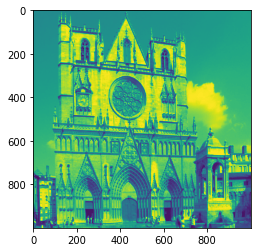

In [37]:
image_path ='../input/architectural-styles-periods-dataset/Capstone_Architectural_Styles_dataset/Early_Christian_Medieval/Gothic architecture/31103.jpg'
image = keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size= (1000,1000))
input_arr = keras.preprocessing.image.img_to_array(image)

plt.imshow(input_arr)

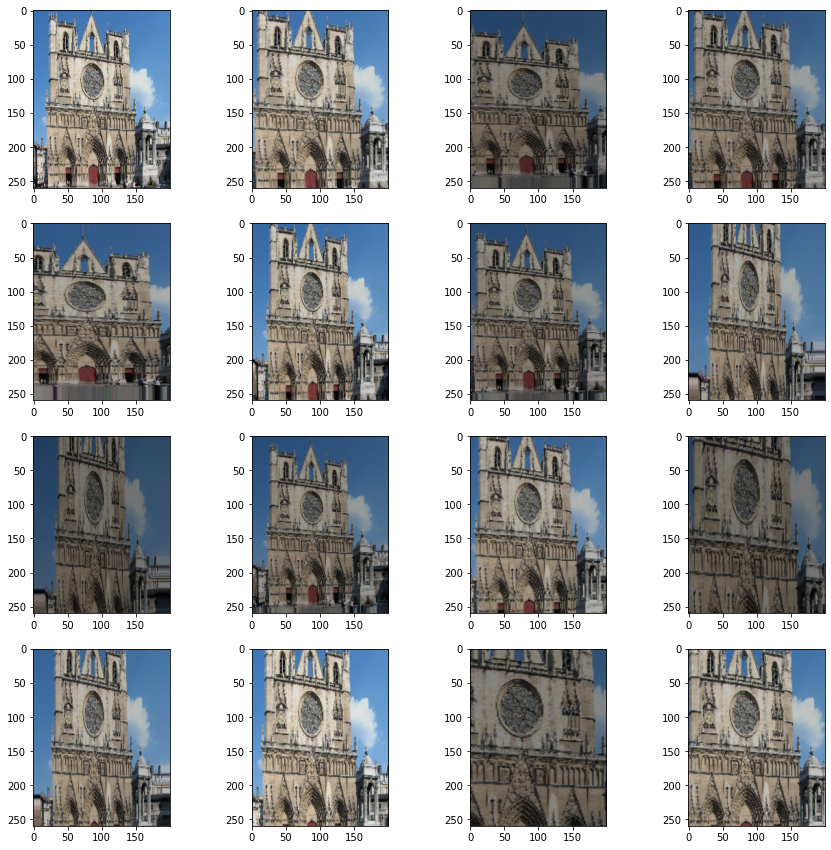

In [41]:
from numpy import expand_dims


img = keras.preprocessing.image.load_img(image_path, target_size=(260, 260))
data = keras.preprocessing.image.img_to_array(img)
sample = expand_dims(data, 0)
datagen = ImageDataGenerator(zoom_range=[0.5,1.2], shear_range=0.2, brightness_range=(0.4,0.9), fill_mode='nearest')
pic =datagen.flow(sample, batch_size=1)
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    batch = pic.next()
    image_ = batch[0].astype('uint8')
    plt.imshow(image_)
plt.show()

These images show what kinds of augmentations I am doing to my image data before they get processed through my models. Data Augmentation is one of the many methods that help prevent overfitting and was used here for that case as well. I was a bit conservative with what to augment and the range of augmentation as I didn't want to distort images way too past being trainable.

# Model testing

Below I will have some of the models that I trained throughout my experimentations with creating a model. Because when kaggle reruns all the code when it does a save & commit, and it does not save all graphs that have been created throughout the process, I have removed the model.fit lines and do not have any of the graphs for these models. However, I do have what their structure was and my hyperparameters for them. These are just a few of the models out of many since I did have to switch my problem.

In [43]:
def show_acc_loss_graphs(modelhistory):
    """
    Takes in the history of a model and produces graphs that show the accuracy change and the loss on both train and validation sets over epochs
    
    Inputs
    ------
    modelhistory: return output of keras model.fit.
    
    From this the accuracy and loss is gathered from for plotting.
    """
    acc = modelhistory.history['acc']
    val_acc = modelhistory.history['val_acc']
    loss = modelhistory.history['loss']
    val_loss = modelhistory.history['val_loss']
    epochs = range(len(acc))

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(epochs, acc, 'go', label= 'Training Acc')
    plt.plot(epochs, val_acc, 'g', label= 'Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(epochs, loss, 'go', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    return

def show_acc_within_top_k_features(model, test_generator):
    """
    This will take in a keras test image generator and a fully trained keras model
    and generate a graph that shows what the accuracy is for the top 3 features on a graph.
    
    Inputs
    ------
    model: keras model, ideally fully trained. make sure your model is fully trained.
    
    
    test_generator : keras object. MAKE SURE  shuffle = False IN YOUR GENERATOR IN ORDER FOR THIS TO WORK.
    Created in my project in the form of ImageDataGenerator.flow_from_directory() where the flow comes from the test directory. 
    If you have generated your data in any other form using flow, (flow from batch, or just flow) this will work for it as well
    
    return: None
    """
    y_preds = model.preict(test_generator)
    num_of_classes = len(list(test_generator.class_indices.keys()))
    k_range = np.linspace(1, num_of_classes, num_of_classes)
    acc_list = []
    for k in k_range:
        acc = np.sum(tf.math.in_top_k(predictions= y_preds, targets= test_generator.classes, k=k))/len(y_preds)
        acc_list.append(acc)
        
    plt.figure(figsize=(7,7))
    plt.xlabel('Number of top features',{'fontsize':12})
    plt.ylabel('Accuracy Score',{'fontsize':12})
    plt.title("Accuracy within top K features", {'fontsize':15})
    plt.axvline(x=3, ymin=0, ymax=1, c='red',label="Top 3 feature cutoff")
    plt.plot(k_range, acc_list,linewidth=3, label ="Accuracy per within top k features")
    plt.legend()
    plt.show()
    return

def create_confusion_matrix(model, test_generator):
    """
    Creates an annotated confusion matrix visualized with a seaborn heatmap.
    
    Inputs
    ------
     model: keras model, ideally fully trained. make sure your model is fully trained.
    
    
    test_generator : keras object. MAKE SURE  shuffle = False IN YOUR GENERATOR IN ORDER FOR THIS TO WORK. 
    Created in my project in the form of ImageDataGenerator.flow_from_directory() where the flow comes from the test directory.
    If you have generated your data in any other form using flow, (flow from batch, or just flow) this will work for it as well.
    
    return: None
    """
    y_preds = model.predict(test_generator)
    cm = confusion_matrix(test_generator.classes, np.argmax(y_preds, axis=1))
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, xticklabels= list(test_generator.class_indices.keys()), yticklabels= list(test_generator.class_indices.keys()), annot= True)
    plt.show()
    return

## Models

Here I show the summary of some of the models that I tried throughout my experimentation. As mentioned before I have removed the .fit for them (and subsequently the graphs) because I do not have access to enough gpu time on kaggle. The final model listed in this list is the one that worked best and ultimately the one I choose.

In [47]:
model_0 = models.Sequential()

model_0.add(layers.Conv2D(32, (7,7), activation= 'relu', input_shape=(520,400, 3)))
model_0.add(layers.MaxPooling2D((2,2)))

model_0.add(layers.Conv2D(64, (7,7), activation= 'relu'))
model_0.add(layers.MaxPooling2D((2,2)))

model_0.add(layers.Conv2D(64, (7,7), activation ='relu'))
model_0.add(layers.MaxPooling2D((2,2)))

model_0.add(layers.Conv2D(128, (3,3), activation ='relu'))
model_0.add(layers.MaxPooling2D((2,2)))

model_0.add(layers.Flatten())
model_0.add(layers.Dense(50, activation='relu'))
model_0.add(layers.Dense(9, activation='softmax'))

model_0.compile(optimizer='sgd',loss='categorical_crossentropy', metrics= ['acc'])
model_0.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 514, 394, 32)      4736      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 257, 197, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 251, 191, 64)      100416    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 125, 95, 64)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 119, 89, 64)       200768    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 59, 44, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 57, 42, 128)      

In [48]:
model_00 = models.Sequential()

model_00.add(layers.Conv2D(32, (7,7), activation= 'relu', input_shape=(520,400, 3)))
model_00.add(layers.MaxPooling2D((2,2)))

model_00.add(layers.Conv2D(64, (7,7), activation= 'relu'))
model_00.add(layers.MaxPooling2D((2,2)))


model_00.add(layers.Conv2D(128, (3,3), activation ='relu'))
model_00.add(layers.MaxPooling2D((2,2)))

model_00.add(layers.Flatten())
model_00.add(layers.Dense(50, activation='relu'))
model_00.add(layers.Dense(9, activation='softmax'))

model_00.compile(optimizer='sgd',loss='categorical_crossentropy', metrics= ['acc'])
model_00.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 514, 394, 32)      4736      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 257, 197, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 251, 191, 64)      100416    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 125, 95, 64)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 123, 93, 128)      73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 61, 46, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 359168)           

In [50]:
model_1 = models.Sequential()

model_1.add(layers.Conv2D(32, (7,7), activation= 'relu', input_shape=(520,400, 3)))
model_1.add(layers.MaxPooling2D((2,2)))


model_1.add(layers.Conv2D(64, (5,5), activation ='relu'))
model_1.add(layers.MaxPooling2D((2,2)))

model_1.add(layers.Conv2D(128, (5,5), activation ='relu'))
model_1.add(layers.MaxPooling2D((2,2)))

model_1.add(layers.Conv2D(256, (5,5), activation ='relu'))
model_1.add(layers.MaxPooling2D((2,2)))

model_1.add(layers.Conv2D(512, (5,5), activation ='relu'))
model_1.add(layers.MaxPooling2D((2,2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(250, activation='relu'))
model_1.add(layers.Dense(9, activation='softmax'))

model_1.compile(optimizer='sgd',loss='categorical_crossentropy', metrics= ['acc'])
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 514, 394, 32)      4736      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 257, 197, 32)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 253, 193, 64)      51264     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 126, 96, 64)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 122, 92, 128)      204928    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 61, 46, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 57, 42, 256)      

In [51]:
model_2 = models.Sequential()

model_2.add(layers.Conv2D(32, (7,7), activation= 'relu', input_shape=(520,400, 3)))
model_2.add(layers.MaxPooling2D((2,2)))

model_2.add(layers.Conv2D(64, (5,5), activation ='relu'))
model_2.add(layers.MaxPooling2D((2,2)))

model_2.add(layers.Conv2D(128, (5,5), activation ='relu'))
model_2.add(layers.MaxPooling2D((2,2)))

model_2.add(layers.Conv2D(256, (5,5), activation ='relu'))
model_2.add(layers.MaxPooling2D((2,2)))

model_2.add(layers.Conv2D(512, (3,3), activation ='relu'))
model_2.add(layers.MaxPooling2D((2,2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(250, activation='relu'))
model_2.add(layers.Dense(9, activation='softmax'))

model_2.compile(optimizer='sgd',loss='categorical_crossentropy', metrics= ['acc'])
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 514, 394, 32)      4736      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 257, 197, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 253, 193, 64)      51264     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 126, 96, 64)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 122, 92, 128)      204928    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 61, 46, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 57, 42, 256)      

In [52]:
model_3 = models.Sequential()

model_3.add(layers.Conv2D(16, (9,9), activation= 'relu', input_shape= (520,400,3)))
model_3.add(layers.Dropout(0.3))
model_3.add(layers.Conv2D(32, (7,7), activation= 'relu'))
model_3.add(layers.MaxPooling2D((2,2)))


model_3.add(layers.Conv2D(32, (7,7), activation= 'relu'))
model_3.add(layers.MaxPooling2D((2,2)))
model_3.add(layers.Dropout(0.3))

model_3.add(layers.Conv2D(32, (5,5), activation ='relu'))
model_3.add(layers.MaxPooling2D((2,2)))

model_3.add(layers.Conv2D(64, (5,5), activation ='relu'))
model_3.add(layers.MaxPooling2D((2,2)))
model_3.add(layers.Dropout(0.3))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(100, activation='relu'))
model_3.add(layers.Dense(9, activation='softmax'))

In [53]:
myoptimizer = keras.optimizers.SGD(learning_rate= 0.03)
model_3.compile(optimizer= myoptimizer, loss='categorical_crossentropy', metrics= ['acc'])
model_3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 512, 392, 16)      3904      
_________________________________________________________________
dropout (Dropout)            (None, 512, 392, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 506, 386, 32)      25120     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 253, 193, 32)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 247, 187, 32)      50208     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 123, 93, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 123, 93, 32)      

In [54]:
model = models.Sequential()

model.add(layers.Conv2D(64, (5,5), activation= 'relu',padding= 'same', input_shape= (260,200,3)))
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Conv2D(128, (3,3), padding= 'same', activation= 'relu'))
model.add(layers.Conv2D(128, (3,3), padding= 'same', activation= 'relu'))
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Conv2D(256, (3,3), padding= 'same', activation ='relu'))
model.add(layers.Conv2D(256, (3,3), padding= 'same', activation ='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(512, (3,3), padding= 'same', activation ='relu'))
model.add(layers.Conv2D(512, (3,3), padding= 'same', activation ='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(512, (3,3), padding= 'same', activation ='relu'))
model.add(layers.Conv2D(512, (3,3), padding= 'same', activation ='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [55]:
myoptimizer = keras.optimizers.Adam(learning_rate= 3e-4)
model.compile(optimizer= myoptimizer, loss='categorical_crossentropy', metrics= ['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 260, 200, 64)      4864      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 130, 100, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 130, 100, 128)     73856     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 130, 100, 128)     147584    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 65, 50, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 65, 50, 256)       295168    
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 65, 50, 256)      